In [1]:
import pandas as pd
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Compassion_topics_minsize7.csv')

In [3]:
df.head(1)

,Experiment,File Name,Id,Start Time,End Time,Speaker,Content,Condition,Order Condition,utterance_index,Speaker_original,preprocessed_content,one_topic,one_topic_name
0,Compassion,S301final,301,"00:00:29,640","00:00:34,820",Participant,the points i think are like meditating.,1,Unknown,3,Participant,point meditating,0,0_feeling_sort_little_sensation


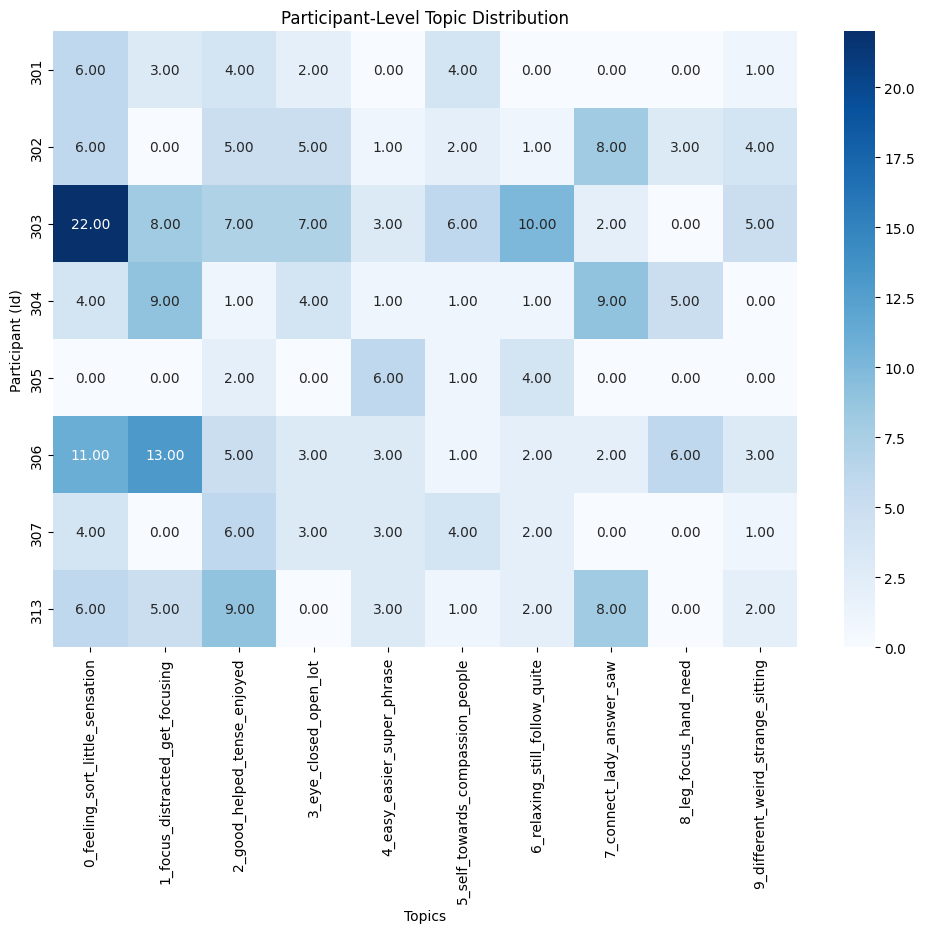

In [4]:
# Count how many utterances of each topic per participant
participant_topic_counts = (
    df.groupby(["Id", "one_topic_name"])
    .size()
    .reset_index(name="Count")  # This gives a table of (Id, topic, count)
)

# Pivot the data: rows = participant (Id), columns = topics
participant_topic_matrix = participant_topic_counts.pivot(
    index="Id",
    columns="one_topic_name",
    values="Count"
).fillna(0)

plt.figure(figsize=(12, 8))

# If it's counts, you might want a log scale or robust scaling. If it's proportions, the default is fine.
sns.heatmap(
    participant_topic_matrix,
    cmap="Blues",
    annot=True,     # show numeric values
    fmt=".2f"       # format numbers to 2 decimals
)

plt.title("Participant-Level Topic Distribution")
plt.ylabel("Participant (Id)")
plt.xlabel("Topics")
plt.show()

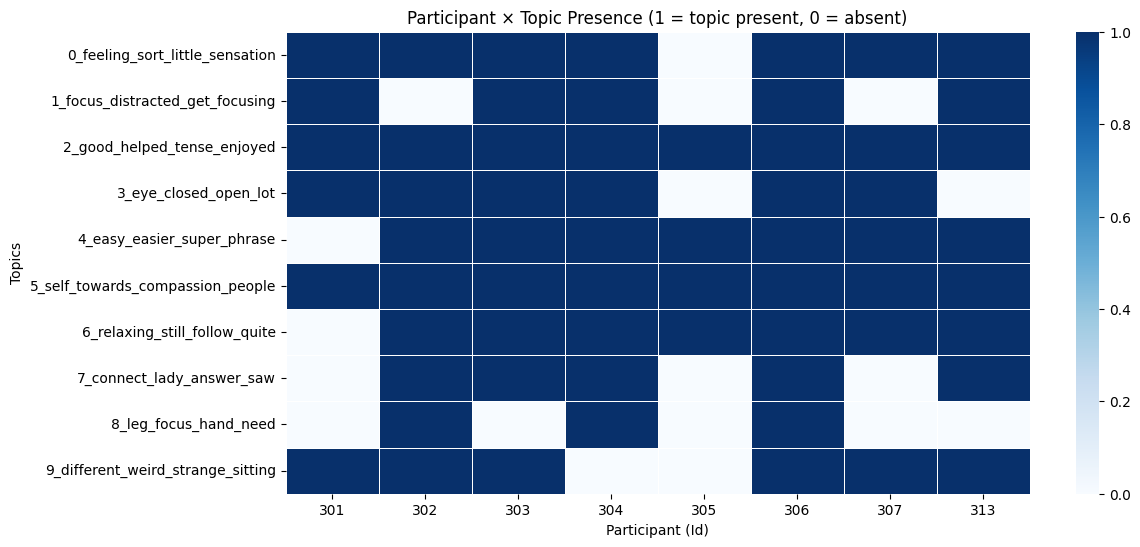

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example DataFrame structure:
# df = pd.DataFrame({
#     "Id": [...],
#     "Condition": [...],
#     "one_topic_name": [...],
#     "Content": [...]
# })

# 1. Count occurrences of each topic by participant
participant_topic_counts = (
    df.groupby(["Id", "one_topic_name"])["Content"]
    .size()
    .reset_index(name="Count")
)

# 2. Convert any Count > 0 to presence = 1
participant_topic_counts["Presence"] = (participant_topic_counts["Count"] > 0).astype(int)

# 3. Pivot to create a presence matrix
presence_matrix = participant_topic_counts.pivot(
    index="one_topic_name", 
    columns="Id", 
    values="Presence"
).fillna(0)

# 4. Visualize as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    presence_matrix, 
    cmap="Blues", 
    linewidths=.5,
)
plt.title("Participant × Topic Presence (1 = topic present, 0 = absent)")
plt.ylabel("Topics")
plt.xlabel("Participant (Id)")
plt.show()

In [7]:
# 1. Group by File Name and topic, then count
file_topic_counts = (
    df.groupby(["File Name", "one_topic_name"])
    .size()
    .reset_index(name="Count")
)

# 2. For each file, compute the total utterance count
total_counts_per_file = file_topic_counts.groupby("File Name")["Count"].sum().reset_index(name="TotalCount")

# 3. Merge to calculate percentages
file_topic_counts = file_topic_counts.merge(total_counts_per_file, on="File Name", how="left")
file_topic_counts["Percentage"] = file_topic_counts["Count"] / file_topic_counts["TotalCount"] * 100

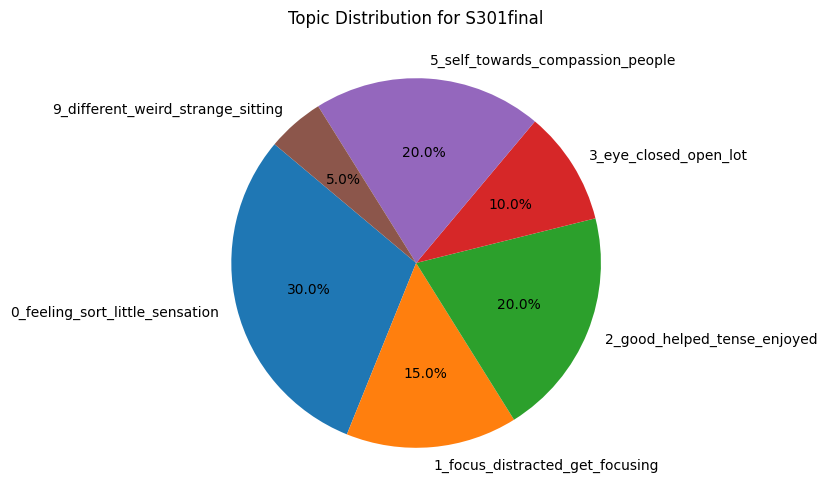

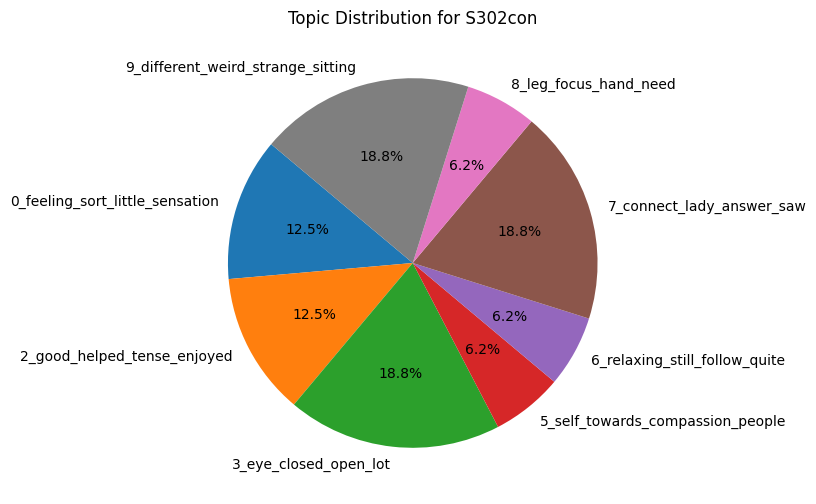

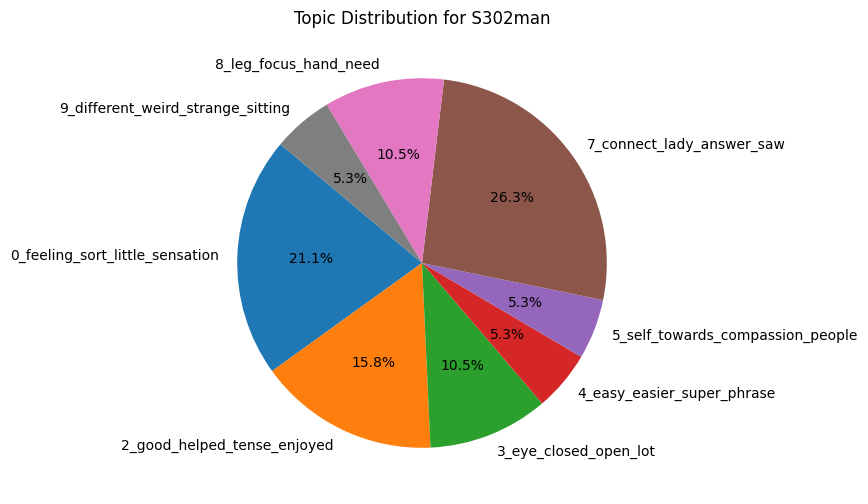

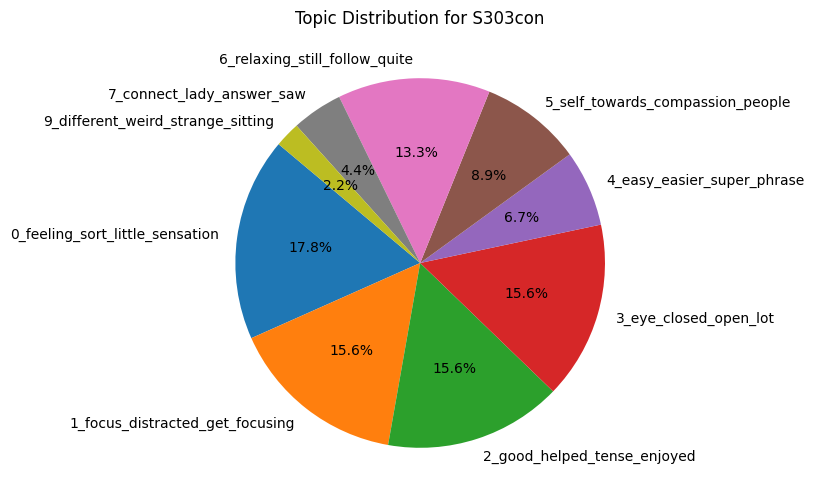

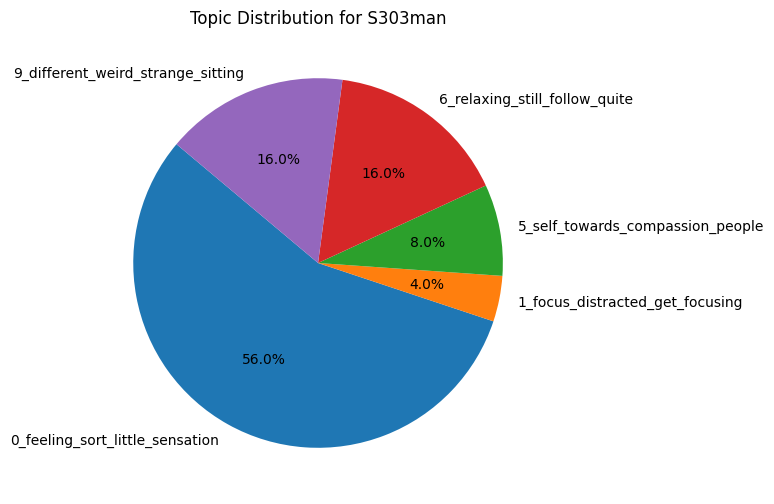

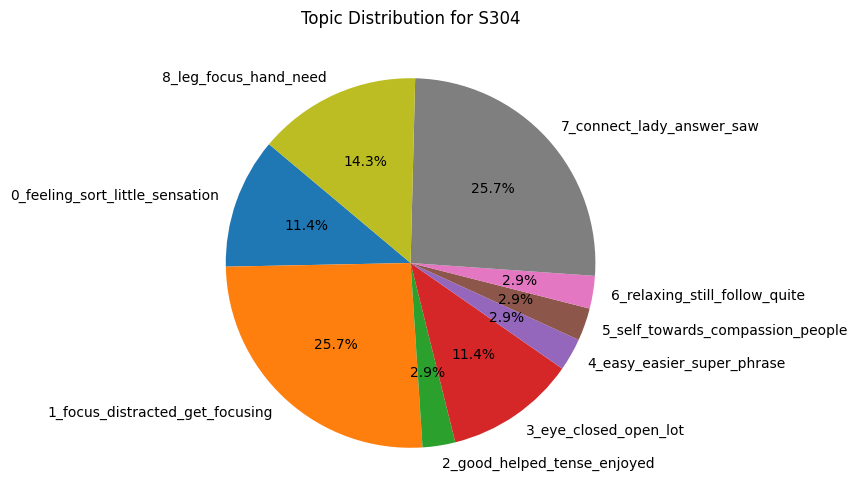

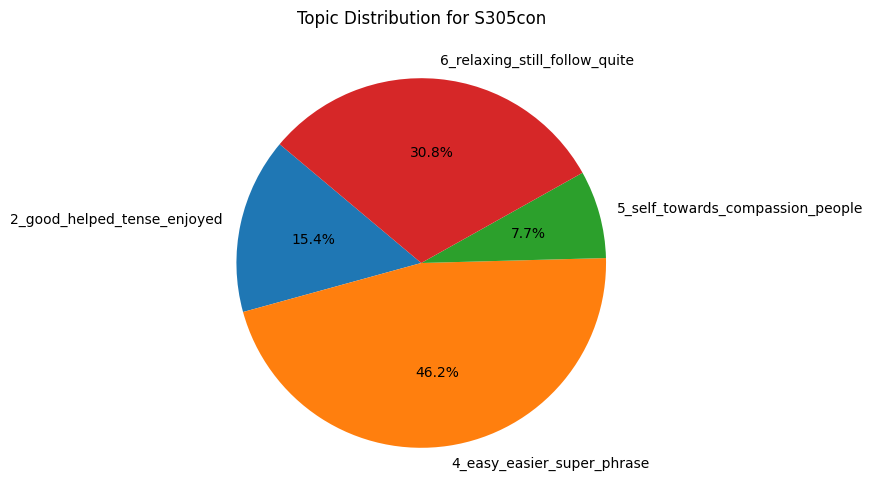

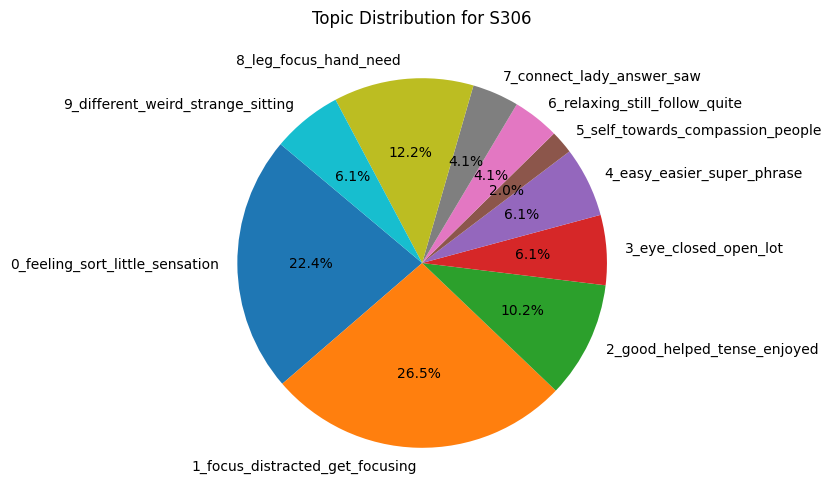

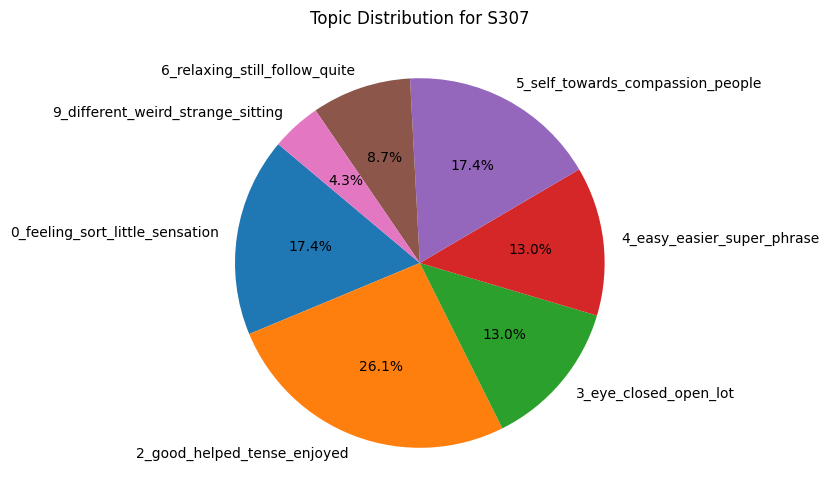

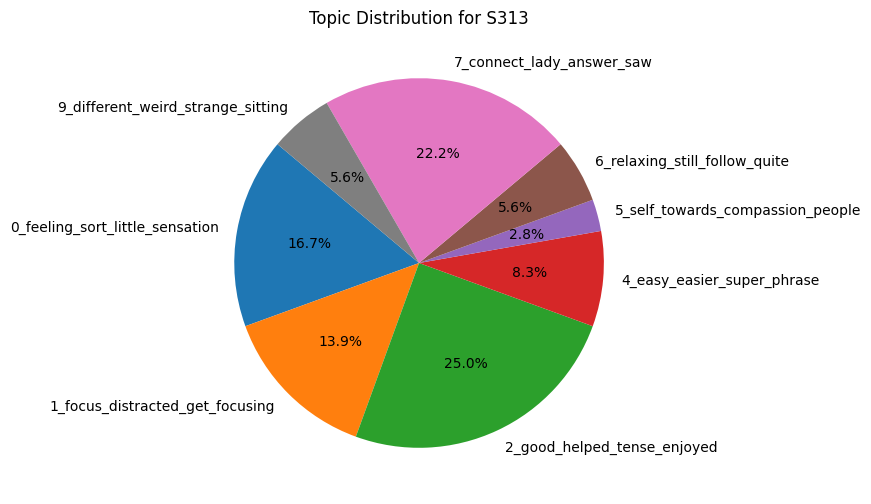

In [8]:
# Group by file to create individual plots
for file_name, group in file_topic_counts.groupby("File Name"):
    # group contains rows for just this file
    topics = group["one_topic_name"]
    percentages = group["Percentage"]

    plt.figure(figsize=(6, 6))
    plt.pie(
        percentages, 
        labels=topics, 
        autopct="%.1f%%", 
        startangle=140
    )
    plt.title(f"Topic Distribution for {file_name}")
    plt.show()


# Networks

In [14]:
# Group transitions by file (interview)
interview_networks = {}
for file_name, group in df.groupby("File Name"):
    # Sort utterances by logical order
    group = group.sort_values("utterance_index")
    topics = group["one_topic_name"].tolist()
    
    # Extract transitions between consecutive topics
    transitions = [(topics[i], topics[i + 1]) for i in range(len(topics) - 1)]
    transition_counts = pd.DataFrame(transitions, columns=["Source", "Target"]).value_counts().reset_index(name="Weight")
    
    # Save transitions and node data for this interview
    interview_networks[file_name] = {
        "transitions": transition_counts,
        "nodes": group["one_topic_name"].value_counts().to_dict(),
        "meta": group[["Id", "Condition"]].iloc[0].to_dict(),  # Assume consistent metadata for the file
    }


In [17]:
# Function to create a network for an interview
def create_interview_network( data):
    # Initialize a directed graph
    G = nx.DiGraph()

    # Add nodes with weights
    for node, weight in data["nodes"].items():
        G.add_node(node, weight=weight)

    # Add edges with weights
    for _, row in data["transitions"].iterrows():
        G.add_edge(row["Source"], row["Target"], weight=row["Weight"])

    return G

# Function to visualize the network
def visualize_network(file_name, G, meta):
    # Create a Pyvis Network
    net = Network(height="800px", width="100%", directed=True)
    
    # Add nodes
    for node, data in G.nodes(data=True):
        net.add_node(
            node, 
            title=f"Topic: {node}<br>Frequency: {data['weight']}", 
            value=data["weight"]
        )
    
    # Add edges
    for source, target, data in G.edges(data=True):
        net.add_edge(
            source, 
            target, 
            value=data["weight"], 
            title=f"Transition Count: {data['weight']}"
        )
    
    # Set metadata in the title
    net.title = f"Interview Network: {file_name} (Participant: {meta['Id']}, Condition: {meta['Condition']})"
    

